In [3249]:
def Laplace_Jacobi_slow(Phi):
    # Don't use, very slow AND inefficient
    Phi_new = Phi.copy()
    Nx, = Phi.shape
    for xi in range(1, Nx-1):
        Phi_new[xi] = 0.5*(Phi[xi+1] + Phi[xi-1])

    Phi = Phi_new
    return Phi

In [3250]:
def Laplace_Jacobi(Phi):
    """One update in the Jacobi algorithm"""
    Phi[1:-1] = 0.5*(Phi[2:, 1:-1] + Phi[0:-2, 1:-1] + Phi[1:-1, 2:] + Phi[1:-1, 0:-2])
    return Phi

In [3251]:
def Laplace_Gauss_Seidel(Phi):
    """One update in the Gauss-Seidel algorithm"""
    Nx, Ny = Phi.shape
    for xi in range(1, Nx-1):
        for yj in range(1, Ny-1):
            Phi[xi, yj] = 0.25*(Phi[xi+1, yj] + Phi[xi-1, yj]
                                + Phi[xi, yj+1] + Phi[xi, yj-1])
    return Phi

In [3252]:
def Laplace_Gauss_Seidel_odd_even(Phi):
    """One update in the Gauss-Seidel algorithm on odd or even fields"""
    # odd update (uses old even)
    Phi[1:-2:2, 1:-2:2] = 0.25*(Phi[2::2, 1:-2:2] + Phi[0:-2:2, 1:-2:2] + Phi[1:-2:2, 2::2] + Phi[1:-2:2, 0:-2:2])
    Phi[2:-1:2, 2:-1:2] = 0.25*(Phi[3::2, 2:-1:2] + Phi[1:-2:2, 2:-1:2] + Phi[2:-1:2, 3::2] + Phi[2:-1:2, 1:-2:2])
    
    # even update (uses new odd)
    Phi[1:-2:2, 2:-1:2] = 0.25*(Phi[2::2, 2:-1:2] + Phi[0:-2:2, 2:-1:2] + Phi[1:-2:2, 3::2] + Phi[1:-2:2, 1:-1:2])
    Phi[2:-1:2, 1:-2:2] = 0.25*(Phi[3::2, 1:-2:2] + Phi[1:-2:2, 1:-2:2] + Phi[2:-1:2, 2::2] + Phi[2:-1:2, 0:-2:2])
    return Phi

In [3253]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3254]:
# for interactive work
%matplotlib widget

In [3255]:
%matplotlib inline

In [3256]:
def plot_contour(Phi, filename=None, zlabel=r"potential $\Phi$ (V)",
                 cmap=plt.cm.coolwarm):
    """Plot Phi as a contour plot.
    
    Arguments
    ---------
    Phi : 2D array
          potential on lattice
    filename : string or None, optional (default: None)
          If `None` then show the figure and return the axes object.
          If a string is given (like "contour.png") it will only plot 
          to the filename and close the figure but return the filename.
    cmap : colormap
          pick one from matplotlib.cm          
    """
    fig = plt.figure(figsize=(5,4))
    ax = fig.add_subplot(111)

    x = np.arange(Phi.shape[0])
    y = np.arange(Phi.shape[1])
    X, Y = np.meshgrid(x, y)
    Z = Phi[X, Y]
    cset = ax.contourf(X, Y, Z, 20, cmap=cmap)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_aspect(1)

    cb = fig.colorbar(cset, shrink=0.5, aspect=5)
    cb.set_label(zlabel)
    
    if filename:
        fig.savefig(filename)
        plt.close(fig)
        return filename
    else:
        return ax
    

def plot_surf(Phi, filename=None, offset=-20, zlabel=r'potential $\Phi$ (V)',
             elevation=40, azimuth=-65, cmap=plt.cm.coolwarm):
    """Plot Phi as a 3D plot with contour plot underneath.
    
    Arguments
    ---------
    Phi : 2D array
          potential on lattice
    filename : string or None, optional (default: None)
          If `None` then show the figure and return the axes object.
          If a string is given (like "contour.png") it will only plot 
          to the filename and close the figure but return the filename.
    offset : float, optional (default: 20)
          position the 2D contour plot by offset along the Z direction
          under the minimum Z value
    zlabel : string, optional
          label for the Z axis and color scale bar
    elevation : float, optional
          choose elevation for initial viewpoint
    azimuth : float, optional
          chooze azimuth angle for initial viewpoint
    cmap : colormap
          pick one from matplotlib.cm
    """
     
    x = np.arange(Phi.shape[0])
    y = np.arange(Phi.shape[1])
    X, Y = np.meshgrid(x, y)
    Z = Phi[X, Y]
        
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_wireframe(X, Y, Z, rstride=2, cstride=2, linewidth=0.5, color="gray")
    surf = ax.plot_surface(X, Y, Z, cmap=cmap, alpha=0.6)
    cset = ax.contourf(X, Y, Z, 20, zdir='z', offset=offset+Z.min(), cmap=cmap)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel(zlabel)
    ax.set_zlim(offset + Z.min(), Z.max())
    
    ax.view_init(elev=elevation, azim=azimuth)

    cb = fig.colorbar(surf, shrink=0.5, aspect=5)
    cb.set_label(zlabel)
    
    if filename:
        fig.savefig(filename)
        plt.close(fig)
        return filename
    else:
        return ax

In [3257]:
from tqdm import tqdm

In [3258]:
Max_iter=300
tol = 1e-3
Nmax = 1000
Phi = np.zeros(Nmax, dtype=np.float64)
Phi_old = np.zeros_like(Phi)

# initialize boundaries
# everything starts out zero so nothing special for the grounded wires
Phi[0] = 100     # wire at x=0 at 100 V

for n_iter in tqdm(range(Max_iter)):
    
    Phi_old[:] = Phi
    Phi = Laplace_Jacobi_slow(Phi)
    DeltaPhi = np.linalg.norm(Phi - Phi_old)
    if DeltaPhi < tol:
        print("Laplace_Gauss_Seidel_odd_even converged in {0} iterations to {1}".format(n_iter+1, DeltaPhi))
        break
else:
    print("Laplace_Gauss_Seidel_odd_even did NOT converge in {0} iterations, DeltaPhi={1}".format(n_iter+1, DeltaPhi))
    

100%|██████████| 300/300 [00:00<00:00, 2410.78it/s]

Laplace_Gauss_Seidel_odd_even did NOT converge in 300 iterations, DeltaPhi=0.5213307370122618


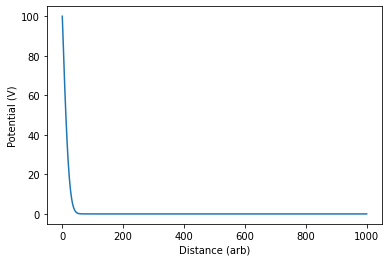

In [3259]:
#plot_contour(Phi);
xp = np.linspace(0, Nmax, num=Nmax)

plt.figure() 
plt.ylabel('Potential (V)')
plt.xlabel('Distance (arb)')
plt.plot(xp, Phi)
plt.show()



In [3260]:
Max_iter=10000
tol = 1e-3
Nmax = 100
omega = 1.99

Phi = np.zeros((Nmax, Nmax), dtype=np.float64)
Phi_old = np.zeros_like(Phi)
residual = np.zeros_like(Phi)

# initialize boundaries
# everything starts out zero so nothing special for the grounded wires
Phi[0, :] = 100     # wire at x=0 at 100 V

for n_iter in tqdm(range(Max_iter)):
    Phi_old[:, :] = Phi
    Phi = Laplace_Gauss_Seidel_odd_even(Phi)
    residual[:, :] = Phi - Phi_old
    DeltaPhi = np.linalg.norm(residual)
    if DeltaPhi < tol:
        print("SOR converged in {0} iterations to {1}".format(n_iter+1, DeltaPhi))
        break
    # SOR
    Phi[:, :] = Phi_old + omega*residual  # = omega*Phi + (1-omega)*Phi_old
else:
    print("SOR did NOT converge in {0} iterations, DeltaPhi={1}".format(n_iter+1, DeltaPhi))


 38%|███▊      | 3796/10000 [00:00<00:00, 9502.00it/s]

SOR converged in 3797 iterations to 0.0009987117944452034


In [3261]:
#plot_surf(Phi);

In [3262]:
import numpy as np
import scipy
import math as m 
import lmfit 
import scipy.integrate as integrate
from cmath import inf

def Poisson_Jacobi(Phi, rho, Delta=1.):
    """One update in the Jacobi algorithm for Poisson's equation"""    
    Phi[1:-1, 1:-1] = 0.25*(Phi[2:, 1:-1] + Phi[0:-2, 1:-1] + Phi[1:-1, 2:] + Phi[1:-1, 0:-2]) \
                      + np.pi * Delta**2 * rho[1:-1, 1:-1]
    return Phi

def Poisson_Gauss_Seidel(Phi, rho, Delta=1.):                   #Changed for 1D
    """One update in the Gauss-Seidel algorithm for Poisson's equation"""    
    Nx, = Phi.shape
    for xi in range(1, Nx-1):
        
        Phi[xi] = 0.5*(Phi[xi+1] + Phi[xi-1]) \
                        + np.pi * Delta**2 * rho[xi]
    return Phi

def Poisson_Gauss_Seidel_odd_even(Phi, rho, Delta=1.):
    """One update in the Gauss-Seidel algorithm on odd or even fields"""
    a = np.pi * Delta**2
    # odd update (uses old even)
    Phi[1:-2:2, 1:-2:2] = 0.25*(Phi[2::2, 1:-2:2] + Phi[0:-2:2, 1:-2:2] 
                                + Phi[1:-2:2, 2::2] + Phi[1:-2:2, 0:-2:2]) + a * rho[1:-2:2, 1:-2:2]
    Phi[2:-1:2, 2:-1:2] = 0.25*(Phi[3::2, 2:-1:2] + Phi[1:-2:2, 2:-1:2] 
                                + Phi[2:-1:2, 3::2] + Phi[2:-1:2, 1:-2:2]) + a * rho[2:-1:2, 2:-1:2]
    
    # even update (uses new odd)
    Phi[1:-2:2, 2:-1:2] = 0.25*(Phi[2::2, 2:-1:2] + Phi[0:-2:2, 2:-1:2] 
                                + Phi[1:-2:2, 3::2] + Phi[1:-2:2, 1:-1:2]) + a * rho[1:-2:2, 2:-1:2]
    Phi[2:-1:2, 1:-2:2] = 0.25*(Phi[3::2, 1:-2:2] + Phi[1:-2:2, 1:-2:2] 
                                + Phi[2:-1:2, 2::2] + Phi[2:-1:2, 0:-2:2]) + a * rho[2:-1:2, 1:-2:2]
    return Phi


def Poisson_Gauss_Seidel_odd_even_1D(Phi, rho, Delta=1.):
    """One update in the Gauss-Seidel algorithm on odd or even fields"""
    a = np.pi * Delta**2
    # odd update (uses old even)
    Phi[1:-2:2] = 0.25*(Phi[2::2] + Phi[0:-2:2] 
                                + Phi[1:-2:2] + Phi[1:-2:2]) + a * rho[1:-2:2]
    Phi[2:-1:2] = 0.25*(Phi[3::2] + Phi[1:-2:2] 
                                + Phi[2:-1:2] + Phi[2:-1:2]) + a * rho[2:-1:2]
    
    # even update (uses new odd)
    Phi[1:-2:2] = 0.25*(Phi[2::2] + Phi[0:-2:2] 
                                + Phi[1:-2:2] + Phi[1:-2:2]) + a * rho[1:-2:2]
    Phi[2:-1:2] = 0.25*(Phi[3::2] + Phi[1:-2:2] 
                                + Phi[2:-1:2] + Phi[2:-1:2]) + a * rho[2:-1:2]
    return Phi

 19%|█▉        | 1922029/10000000 [04:01<16:56, 7949.41it/s]


SOR converged in 1922030 iterations to 0.0009999994743814156


 18%|█▊        | 1812341/10000000 [03:59<18:01, 7571.56it/s]


SOR2 converged in 1812342 iterations to 0.0009999994937429472


  0%|          | 0/10000000 [00:00<?, ?it/s]


0
if
SOR_ion converged in 1 iterations to 0.0
0.0
-0.07238204788796025 -0.07238204788795932


ValueError: x and y must have same first dimension, but have shapes (10000,) and (1000,)

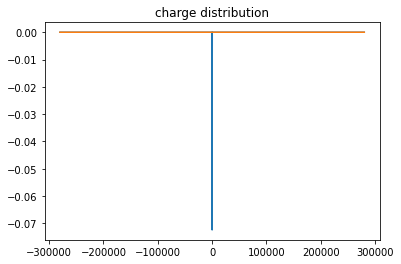

In [3263]:
Nmax = 10000
Max_iter = 10000000
#omega = 1.99
omega = 1.5
tol = 1e-3
echarge = 1.60217663*10**(-19)
eps0 = 8.854*10**(-12)
r_ebeam = 40 #micrometers - radius of electron beam
r_dtube = 28e4 #micrometers - radius of middle drift tube 
#lambe = -1.88501*10**(-9) #line charge density of e-beam @ 8keV and 100mA
qV = ((100)**(3)) * 4*10**(12) 
#lambe = -echarge*qV * np.pi * (r_ebeam*10**(-6))**2 / (eps0*1e6)
lambe = -echarge*qV * (1e-3)**2/ (eps0*1e6)


Nion = 1e12
Zion = 65
kT = 2e-12

def boltzfun(V, q, kT): 
    return np.exp(-q*V/kT)


Phi = np.zeros(Nmax, dtype=np.float64)
Phi_old = np.zeros_like(Phi)
rho = np.zeros_like(Phi)
residual = np.zeros_like(Phi)

Phi2 = np.zeros(Nmax, dtype=np.float64)
Phi_old2 = np.zeros_like(Phi)
rho2 = np.zeros_like(Phi)
residual2 = np.zeros_like(Phi)

Phi3 = np.zeros(Nmax, dtype=np.float64)
Phi_old3 = np.zeros_like(Phi)
rho3 = np.zeros_like(Phi)
residual3 = np.zeros_like(Phi)

# initialize boundaries
Vd = 200

Phi[0] = Vd
Phi[Nmax-1] = Vd    # potential of drift tube at boundaries 

Phi2[0] = Vd 
Phi2[Nmax-1] = Vd

Phi3[0] = Vd
Phi3[Nmax-1] = Vd



for i in range(Nmax):               #potential due to e-beam 
    val1 = i/Nmax 
    b1 = 0.5 - (r_ebeam/r_dtube) 
    b2 = 0.5 + (r_ebeam/r_dtube)
    if val1 < b2 and val1 > b1:
        rho[i] = lambe#*(r_dtube/Nmax)
    else: 
        rho[i] = 0 


Tc = 2*r_dtube * (1/Nmax) * np.sum(rho)


xp = np.linspace(-r_dtube, r_dtube, num=Nmax)


Delta = 0.25

for n_iter in tqdm(range(Max_iter)):
    Phi_old[:] = Phi
    #Phi = Poisson_Gauss_Seidel(Phi, rho, Delta=Delta)
    Phi = Poisson_Gauss_Seidel_odd_even_1D(Phi, rho, Delta=Delta)
    residual[:] = Phi - Phi_old
    DeltaPhi = np.linalg.norm(residual)
    if DeltaPhi < tol:
        print("SOR converged in {0} iterations to {1}".format(n_iter+1, DeltaPhi))
        break
    # SOR
    Phi[:] = Phi_old + omega*residual # = omega*Phi + (1-omega)*Phi_old
else:
    print("SOR did NOT converge in {0} iterations, DeltaPhi={1}".format(n_iter+1, DeltaPhi))


for n_iter in tqdm(range(Max_iter)):
    Phi_old2[:] = Phi2
    #Phi = Poisson_Gauss_Seidel(Phi, rho, Delta=Delta)                                      ##get constant of integration here and find potential, then add potential to rho 
    Phi2 = Poisson_Gauss_Seidel_odd_even_1D(Phi2, 0.3*rho, Delta=Delta)
    residual2[:] = Phi2 - Phi_old2
    DeltaPhi = np.linalg.norm(residual2)
    if DeltaPhi < tol:
        print("SOR2 converged in {0} iterations to {1}".format(n_iter+1, DeltaPhi))
        break
    # SOR
    Phi2[:] = Phi_old2 + omega*residual2 # = omega*Phi + (1-omega)*Phi_old
else:
    print("SOR2 did NOT converge in {0} iterations, DeltaPhi={1}".format(n_iter+1, DeltaPhi))

    
ionrho = np.zeros_like(Phi3)
#ion cloud calculation
for n_iter in tqdm(range(Max_iter)):
    Phi_old3[:] = Phi3
    print(n_iter)
    if n_iter < 1:  
        print('if')
        #Phi_old3[:] = Phi3                    
        Phi3 = Poisson_Gauss_Seidel_odd_even_1D(Phi_old3, rho, Delta=Delta)
        residual3[:] = Phi3 - Phi_old3
        DeltaPhi = np.linalg.norm(residual3)

        if DeltaPhi < tol:
            print("SOR_ion converged in {0} iterations to {1}".format(n_iter+1, DeltaPhi))
            break
            # SOR
            Phi3[:] = Phi_old3 + omega*residual3 # = omega*Phi + (1-omega)*Phi_old
        # else:
        #     print("SOR_ion did NOT converge in {0} iterations, DeltaPhi={1}".format(n_iter+1, DeltaPhi))

    else: 
        print('else')
        Phi_old3[:] = Phi3

        f1 = boltzfun(Phi_old3, Nion*Zion*echarge, kT=kT)
        f1 = f1 - np.min(f1)
        intnorm = np.trapz(f1, dx=2*r_dtube/Nmax)

        # for i in range(Nmax-1):
        #     ionrho[i] = Nion*Zion*echarge/(intnorm*2*r_dtube) * 0.5 * (2*r_dtube/Nmax)*(f1[i] + f1[i+1]) 

        for i in range(Nmax-1):
            rho[i] += Nion*Zion*echarge/(intnorm*2*r_dtube) * 0.5 * (2*r_dtube/Nmax)*(f1[i] + f1[i+1])

        #rhoT = ionrho + rho
        Phi3 = Poisson_Gauss_Seidel_odd_even_1D(Phi_old3, rhoT, Delta=Delta)
        residual3[:] = Phi3 - Phi_old3
        DeltaPhi = np.linalg.norm(residual3)
        if DeltaPhi < tol:
            print("SOR_ion converged in {0} iterations to {1}".format(n_iter+1, DeltaPhi))
            break
            # SOR
            Phi3[:] = Phi_old3 + omega*residual3 # = omega*Phi + (1-omega)*Phi_old
        else:
            print("SOR_ion did NOT converge in {0} iterations, DeltaPhi={1}".format(n_iter+1, DeltaPhi))

print(2*r_dtube*np.sum(ionrho))
print(np.min(rho), np.min(rhoT))
plt.figure()
plt.title('charge distribution')
plt.plot(xp, rho, label='e-beam')
plt.plot(xp, ionrho, label='ions')
plt.plot(xp, rhoT, label='total')
plt.xlim(-r_ebeam*15, 15*r_ebeam)
plt.legend()
plt.show()
plt.close()

plt.figure() 
plt.ylabel('Potential (V)')
#plt.xlabel('Distance (arb)')
plt.xlabel('Distance [micrometers]')
#plt.ylim(0, 250)
#plt.xlim(-r_ebeam*1100, r_ebeam*1100)
#plt.ylim(ymax=0.1)

#plt.plot(xp, Phi, c='b', label='100%')
plt.plot(xp, Phi2, c='r', label='30%')
plt.plot(xp, Phi3, c='g', label='Z=65+ ions')
plt.legend()
plt.show()

# f1 = boltzfun(Phi2, Nion*Zion*echarge, kT=kT)
# f1 = f1 - np.min(f1)
# area1 = np.trapz(f1, dx=2*r_dtube/Nmax)
# area1 = Zion/area1 *np.trapz(f1, dx=2*r_dtube/Nmax)
# print('area1 = ', area1)
# f2 = boltzfun(Phi2, Nion*14*echarge, kT=kT)
# f2 = f2 - np.min(f2)
# plt.figure() 
# plt.ylabel('Boltz dist')
# plt.xlabel('Distance [micrometers]')
# plt.plot(xp, f1, c='g', label='Z=65+ ions')
# plt.plot(xp, f2, label='Z=14+')
# plt.ylim(bottom=0)
# plt.legend()
# plt.show()


In [ ]:
# #plot_surf(Phi, elevation=40, azimuth=20);
# xp = np.linspace(-r_dtube, r_dtube, num=Nmax)

# plt.figure() 
# plt.ylabel('Potential (V)')
# #plt.xlabel('Distance (arb)')
# plt.xlabel('Distance [micrometers]')
# #plt.ylim(0, 250)
# #plt.xlim(-r_ebeam*1100, r_ebeam*1100)
# #plt.ylim(ymax=0.1)

# plt.plot(xp, Phi, c='b', label='100%')
# plt.plot(xp, Phi2, c='r', label='30%')
# plt.legend()
# plt.show()


In [ ]:
def laplacian2d(f, Delta=1):
    """Finite difference approximation of Del^2 f.
        
    Arguments
    ---------
    f : M x N matrix
    Delta : float
    
    Returns
    -------
    M x N matrix, boundaries set to 0
    """
    
    L = np.zeros_like(f, dtype=np.float64)
    L[1:-1, 1:-1] = f[2:, 1:-1] + f[:-2, 1:-1] + f[1:-1, 2:] + f[1:-1, :-2] - 4*f[1:-1, 1:-1]
    return L/Delta**2

def laplacian2dsimple(f, Delta=1):
    L = np.zeros_like(f, dtype=np.float64)
    for i in range(1, L.shape[0]-1):
        for j in range(1, L.shape[1]-1):
            L[i, j] = f[i+1, j] + f[i-1, j] + f[i, j+1] + f[i, j-1] - 4*f[i, j]            
    return L/Delta**2


def laplacian1d(f, Delta=1):
    """Finite difference approximation of Del^2 f.
        
    Arguments
    ---------
    f : M matrix
    Delta : float
    
    Returns
    -------
    M matrix, boundaries set to 0
    """
    
    L = np.zeros_like(f, dtype=np.float64)
    L[1:-1] = f[2:] + f[:-2]  - 4*f[1:-1]
    return L/Delta**2

def laplacian1dsimple(f, Delta=1):
    L = np.zeros_like(f, dtype=np.float64)
    for i in range(1, L.shape[0]-1):
        L[i] = f[i+1] + f[i-1] - 4*f[i]            
    return L/Delta**2

In [ ]:
import numpy as np

def test_laplacian2d():
    ftest = np.random.random((200, 200))
    assert np.allclose(laplacian2d(ftest), laplacian2dsimple(ftest))

def test_laplacian1d():
    ftest = np.random.random((200))
    assert np.allclose(laplacian1d(ftest), laplacian1dsimple(ftest))

test_laplacian2d()

test_laplacian1d()

In [ ]:
#rhox = - laplacian2d(Phi)/(4*np.pi)

rhocal = - laplacian1d(Phi) / (4*np.pi)

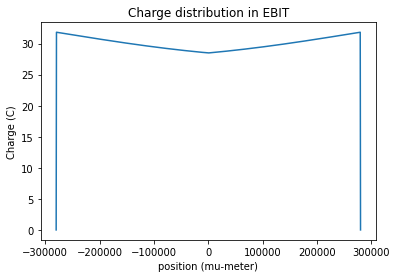

In [ ]:
#plot_contour(rhox, zlabel=r"charge density $\rho$");
plt.figure() 
plt.plot(xp, rhocal)
plt.xlabel('position (mu-meter)')
plt.ylabel('Charge (C)')
plt.title('Charge distribution in EBIT')
plt.show()

In [ ]:
#plot_surf(rhox, zlabel=r"charge density $\rho$", elevation=20, azimuth=20, offset=-3);